# Test validity step 3 : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$ becoming $P(r | ...) \propto s_c^t C(r)^{-1} s_c + ln|C(r)|$

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import jax
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


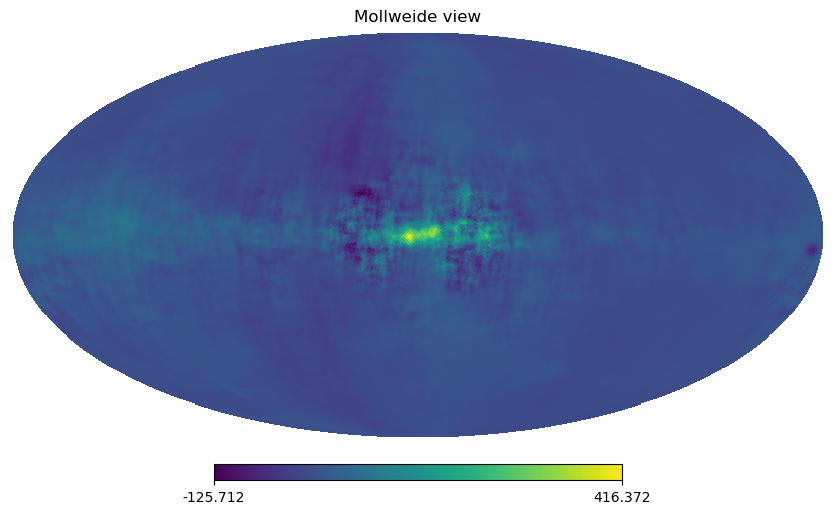

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
# working_directory_path = os.path.abspath('') + '/'
working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v5/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

# path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_full_chain_v1c.toml'
path_toml_file = directory_toml_file + 'biased_full_chain_v1c.toml'

In [6]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [7]:
reduction_noise = 1

In [8]:
freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)

In [9]:
freq_inverse_noise_masked = np.zeros((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.npix))

# nb_pixels_mask = int(mask.sum())
freq_inverse_noise_masked[:,:,:] = np.repeat(freq_inverse_noise.ravel(order='F'), MICMAC_sampler_obj.npix).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.npix), order='C')

MICMAC_sampler_obj.freq_inverse_noise = freq_inverse_noise_masked
freq_inverse_noise = MICMAC_sampler_obj.freq_inverse_noise

In [10]:
instrument = get_instrument(instr_name)

instrument['depth_p'] /= reduction_noise
# get input freq maps
np.random.seed(noise_seed)
# freq_maps = get_observation(instrument, model, nside=NSIDE, noise=noise)[:, 1:, :]   # keep only Q and U
freq_maps_fgs = get_observation(instrument, fgs_model, nside=MICMAC_sampler_obj.nside, noise=noise)[:, 1:, :]   # keep only Q and U


In [11]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

In [12]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.number_components, pos_special_freqs=[0,-1])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.number_components, init_params, pos_special_freqs=[0,-1])

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [13]:
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [14]:
s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps, jax_use=False)[0, :, :]

In [15]:
red_cov_matrix_sample = theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor

In [16]:
s_cML.shape

(2, 49152)

In [17]:
PRNGKey = random.PRNGKey(0)
wiener_filter_term = MICMAC_sampler_obj.solve_generalized_wiener_filter_term_v2(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))

map_random_realization_xi = jnp.empty(0)
map_random_realization_chi = jnp.empty(0)
fluctuation_maps = MICMAC_sampler_obj.get_fluctuating_term_maps_v2(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))

s_c_sample = wiener_filter_term + fluctuation_maps

CG-Python-0 WF finished in  None iterations !!
Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  None iterations !!


In [18]:
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
nside = MICMAC_sampler_obj.nside
n_iter = MICMAC_sampler_obj.n_iter

In [19]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [20]:
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


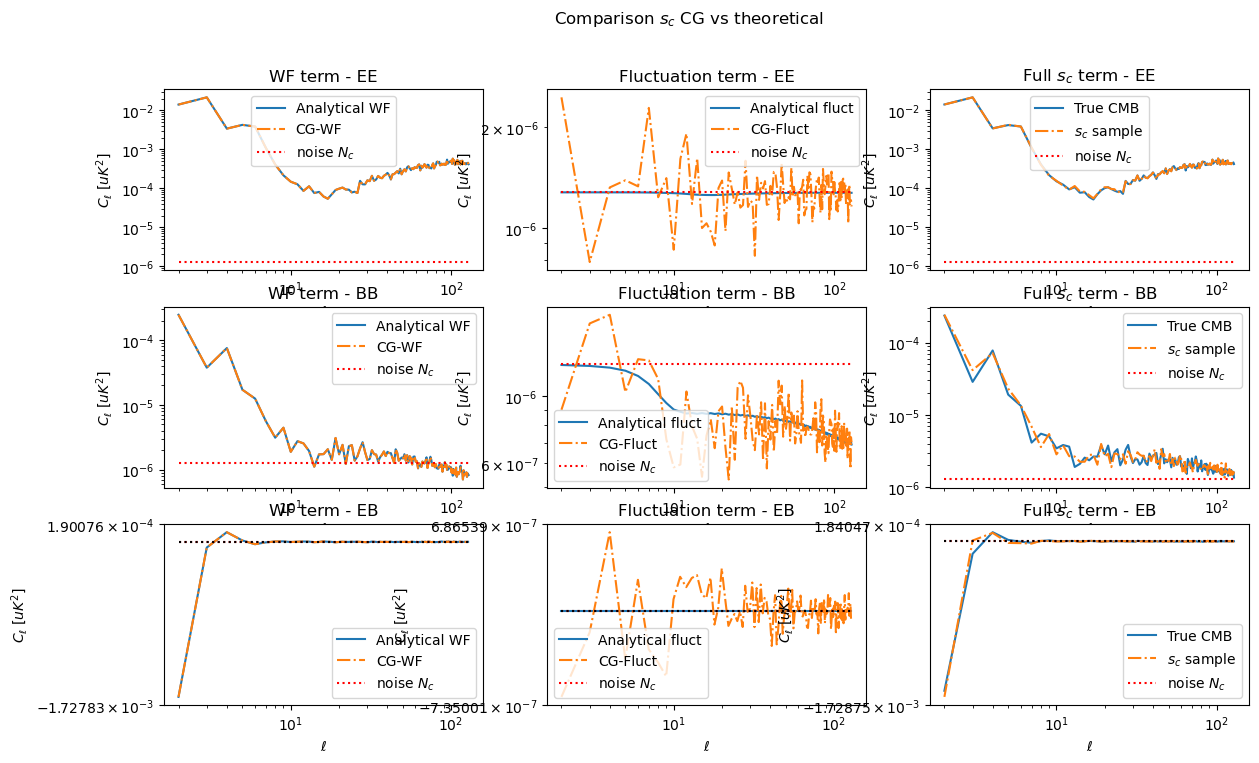

In [21]:
list_correl = ['EE', 'BB', 'EB']

map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=lmax, iter=n_iter)[indices_polar, lmin:]

covariance_noise = np.zeros_like(c_ell_true_CMB)

# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.eye(nstokes)/BtinvNB[0,0])
# # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
# analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)
analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.linalg.pinv(red_cl_noise_harm))
# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
                                                                        analytical_WF_harm, lmin=lmin, n_iter=n_iter)


analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

s_c_WF_maps_extended = np.vstack([np.zeros_like(wiener_filter_term[0,...]), wiener_filter_term])
c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_fluct_maps_extended = np.vstack([np.zeros_like(fluctuation_maps[0,...]), fluctuation_maps])
c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_recovered_ext = np.vstack([np.zeros_like(s_c_sample[0]),s_c_sample])
c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

plt.figure(figsize=(14,8))
plt.suptitle(r"Comparison $s_c$ CG vs theoretical")

for j in range(number_correl_to_plot):
    plt.subplot(331+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, analytical_WF_cells[j,:], label='Analytical WF')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ells_s_c_WF[j,:], '-.', label='CG-WF')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('WF term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()

    plt.subplot(332+3*j)
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_fluct[j,:], '-.', label='CG-Fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Fluctuation term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
    
    plt.subplot(333+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    
    plt.xlabel(r"$\ell$")
    plt.legend()


plt.show()

In [22]:
c_ells_true = jnp.zeros((3,lmax+1))
c_ells_true = c_ells_true.at[:,lmin:].set(micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor))

In [23]:
c_ells_Wishart = jnp.zeros((3,lmax+1))
c_ells_Wishart = micmac.get_cell_from_map_jax(s_c_sample, lmax=MICMAC_sampler_obj.lmax, n_iter=MICMAC_sampler_obj.n_iter)
c_ells_Wishart = c_ells_Wishart.at[:,lmin:].set(micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor))

In [24]:
# true_cmb = np.zeros((6,lmax+1))
# true_cmb[indices_polar,lmin:] = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor)
# map_s_c = hp.synfast(true_cmb, nside, lmax=lmax, new=True)[1:]

In [25]:
PRNGKey = random.PRNGKey(42)

In [26]:
%%time 
red_invWishart_cells = MICMAC_sampler_obj.get_inverse_wishart_sampling_from_c_ells(c_ells_Wishart, PRNGKey)

CPU times: user 1.34 s, sys: 26.8 ms, total: 1.36 s
Wall time: 1.39 s


In [27]:
jitted_get_inverse_wishart_sampling_from_c_ells = jax.jit(MICMAC_sampler_obj.get_inverse_wishart_sampling_from_c_ells)

In [28]:
%%time
red_invWishart_cells_ = jitted_get_inverse_wishart_sampling_from_c_ells(c_ells_Wishart, PRNGKey)

CPU times: user 415 ms, sys: 9.97 ms, total: 425 ms
Wall time: 421 ms


In [29]:
%%time
red_invWishart_cells_ = jitted_get_inverse_wishart_sampling_from_c_ells(c_ells_Wishart, PRNGKey)

CPU times: user 5.78 ms, sys: 2 ms, total: 7.78 ms
Wall time: 2.61 ms


In [30]:
%%time
red_invWishart_cells_ = jitted_get_inverse_wishart_sampling_from_c_ells(c_ells_Wishart, PRNGKey+1)

CPU times: user 5.57 ms, sys: 2.16 ms, total: 7.72 ms
Wall time: 3.04 ms


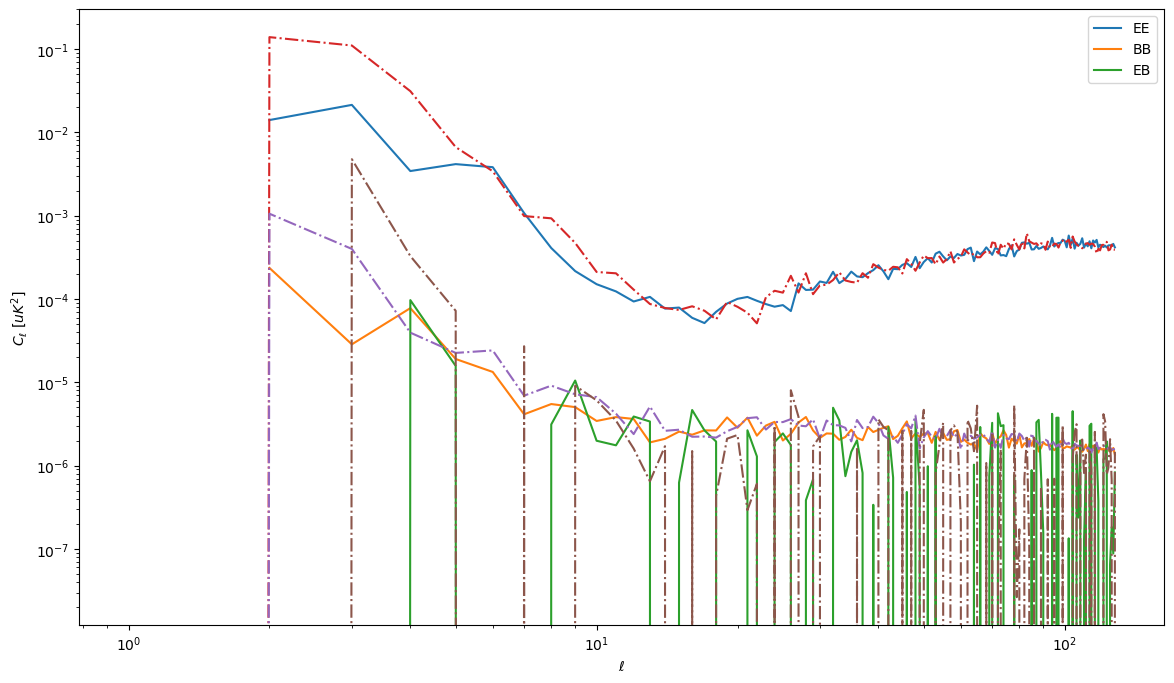

In [31]:
c_ell_results = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_cells)

plt.figure(figsize=(14,8))
plt.plot(np.arange(c_ell_results.shape[-1])[lmin:], c_ell_true_CMB.T)
plt.plot(np.arange(c_ell_results.shape[-1]), c_ell_results.T, '-.')
plt.loglog()
plt.legend(['EE', 'BB', 'EB'])
plt.xlabel(r"$\ell$")
plt.ylabel("$C_\ell$ [$uK^2$]")
plt.show()

# Tests larger scale

In [32]:
c_ells_Wishart_runs = jnp.zeros((3,lmax+1))
c_ells_Wishart_runs = micmac.get_cell_from_map_jax(s_c_sample, lmax=MICMAC_sampler_obj.lmax, n_iter=MICMAC_sampler_obj.n_iter)
c_ells_Wishart_runs = c_ells_Wishart_runs.at[:,lmin:].set(micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor))

In [70]:
nb_simus = 700

In [71]:
%%time 
PRNGKey = random.PRNGKey(42)

red_invWishart_cells_list = jnp.zeros((nb_simus,lmax+1,nstokes,nstokes))
for i in range(nb_simus):
    PRNGKey, subkey = random.split(PRNGKey)
    red_invWishart_cells_list = red_invWishart_cells_list.at[i].set(jitted_get_inverse_wishart_sampling_from_c_ells(c_ells_Wishart_runs, PRNGKey))

CPU times: user 4.5 s, sys: 601 ms, total: 5.1 s
Wall time: 3.2 s


In [78]:
ell_chosen = 10
red_invWishart_scipy = np.zeros((nb_simus,lmax+1,nstokes,nstokes))
red_c_ells_Wishart_runs = get_reduced_matrix_from_c_ell(c_ells_Wishart_runs)

for ell_chosen in range(lmin, lmax+1):
    # for i in range(nb_simus):

    red_invWishart_scipy[:,ell_chosen,...] = scipy.stats.invwishart.rvs(df=2*ell_chosen+1-nstokes, scale=red_c_ells_Wishart_runs[ell_chosen]*(2*ell_chosen+1), size=nb_simus)

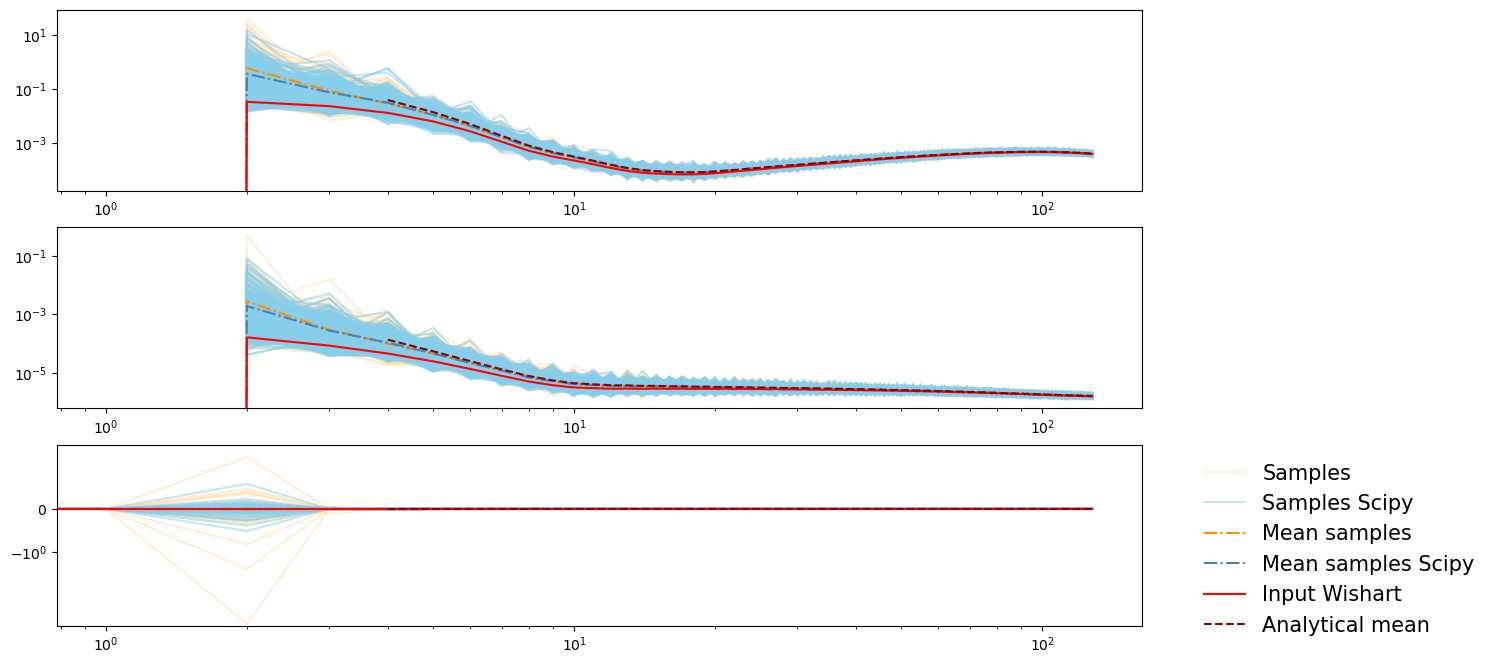

In [87]:
ell_arange = np.arange(lmax+1)

mean_c_ell_results = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_cells_list.mean(axis=0))
mean_c_ell_results_scipy = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_scipy.mean(axis=0))

lmin_mean = 4
factor_ell = ((2*ell_arange+1)/(2*ell_arange+1 - 2 - 2*MICMAC_sampler_obj.nstokes))[lmin_mean:]

alpha_value = .5

plt.figure(figsize=(14,8))
for j in range(number_correl_to_plot):
    plt.subplot(311+j)    
    
    c_ell_results = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_cells_list[0,...])
    plt.plot(ell_arange, c_ell_results[j,:], alpha=alpha_value, color='navajowhite', label='Samples')
    for k in range(1,nb_simus):
        c_ell_results = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_cells_list[k,...])
        plt.plot(ell_arange, c_ell_results[j,:], color='navajowhite', alpha=alpha_value)

    

    c_ell_results_scipy = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_scipy[0,...])
    plt.plot(ell_arange, c_ell_results_scipy[j,:], alpha=alpha_value, color='skyblue', label='Samples Scipy')
    for k in range(1,nb_simus):
        c_ell_results_scipy = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_scipy[k,...])
        plt.plot(ell_arange, c_ell_results_scipy[j,:], color='skyblue', alpha=alpha_value)

    plt.plot(ell_arange, mean_c_ell_results[j,:], '-.', color='darkorange', label='Mean samples')
    plt.plot(ell_arange, mean_c_ell_results_scipy[j,:], '-.', color='steelblue', label='Mean samples Scipy')
    
    plt.plot(ell_arange, c_ells_Wishart_runs[j,:], color='red', label='Input Wishart')
    plt.plot(ell_arange[lmin_mean:], c_ells_Wishart_runs[j,lmin_mean:]*factor_ell, '--', color='darkred', label='Analytical mean')

    
    plt.xscale('log')
    if j <= nstokes-1:
        plt.yscale('log')
    else:
        plt.yscale('symlog')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
plt.show()

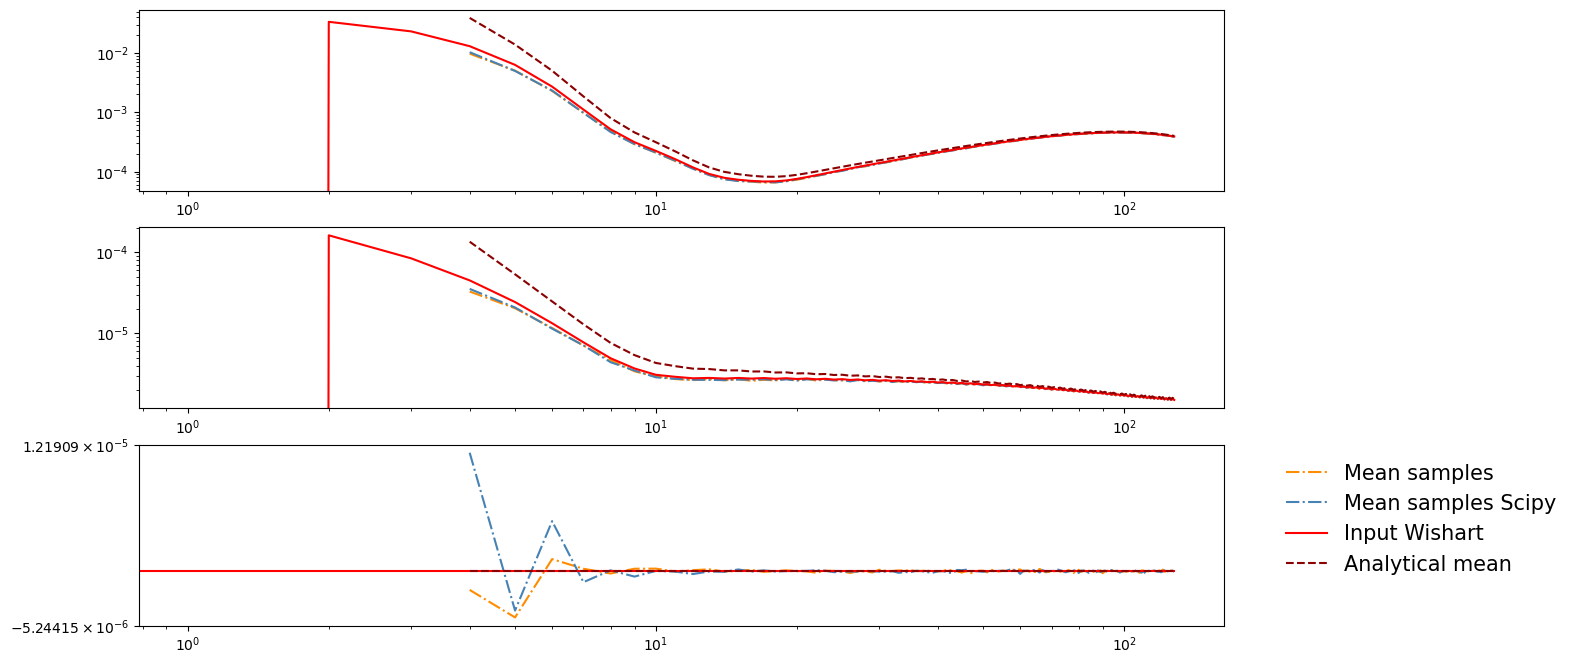

In [93]:
ell_arange = np.arange(lmax+1)

mean_c_ell_results = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_cells_list.mean(axis=0))
mean_c_ell_results_scipy = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_scipy.mean(axis=0))

lmin_mean = 4
factor_ell = ((2*ell_arange+1)/(2*ell_arange+1 - 2 - 2*MICMAC_sampler_obj.nstokes))[lmin_mean:]

alpha_value = .5

plt.figure(figsize=(14,8))
for j in range(number_correl_to_plot):
    plt.subplot(311+j)    
    
    plt.plot(ell_arange[lmin_mean:], mean_c_ell_results[j,lmin_mean:]/factor_ell, '-.', color='darkorange', label='Mean samples')
    plt.plot(ell_arange[lmin_mean:], mean_c_ell_results_scipy[j,lmin_mean:]/factor_ell, '-.', color='steelblue', label='Mean samples Scipy')
    
    plt.plot(ell_arange, c_ells_Wishart_runs[j,:], color='red', label='Input Wishart')
    plt.plot(ell_arange[lmin_mean:], c_ells_Wishart_runs[j,lmin_mean:]*factor_ell, '--', color='darkred', label='Analytical mean')

    
    plt.xscale('log')
    if j <= nstokes-1:
        plt.yscale('log')
    else:
        plt.yscale('symlog')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
plt.show()